# Dimensionality Reduction and Classification

Here I experiment with various dimensionality-reduction tools and explore whether they can be used for classification tasks. I'll be using the MNIST 28x28 dataset.

In [1]:
import os
import sys

import pickle
import gzip

import wget
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans

import umap

In [2]:
dir_path = os.path.dirname(os.path.realpath('__file__')) # absolute path of notebook
dataset_path = os.path.join(dir_path, "../data/mnist.pkl.gz")
if not os.path.exists(dataset_path):
    print('Downloading dataset with wget module...')
    if not os.path.exists(os.path.join(dir_path, '../data')):
        os.mkdir(os.path.join(dir_path, '../data'))
    url = 'http://ericjmichaud.com/downloads/mnist.pkl.gz'
    wget.download(url, dataset_path)  
print('Download failed') if not os.path.exists(dataset_path) else print('Dataset acquired')
f = gzip.open(dataset_path, 'rb')
mnist = pickle.load(f)
f.close()
print('Loaded data to variable `mnist`')

Dataset acquired
Loaded data to variable `mnist`


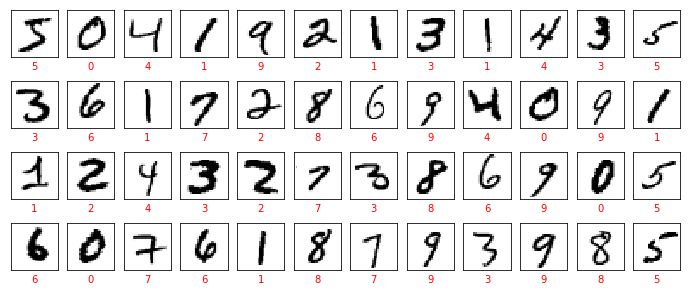

In [3]:
plt.figure(figsize=(12, 5))
for i in range(48):
    plt.subplot(4, 12, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(mnist[i][0].reshape((28, 28)), cmap=plt.cm.binary)
    plt.xlabel(str(np.argmax(mnist[i][1])), color='red')

In [4]:
imgs, lbs = zip(*mnist)
imgs, lbs = np.array(imgs), np.array(lbs)
training_imgs, training_lbs = imgs[:60000], lbs[:60000]
test_imgs, test_lbs = imgs[60000:], lbs[60000:]

### Let's first see how PCA embeds the data into 2-space...

Text(0.5, 1.0, 'PCA Embeddings of MNIST into 2d')

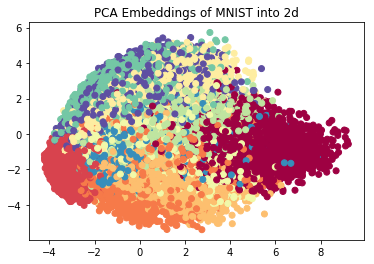

In [5]:
lowd_pca = PCA(n_components=2).fit(training_imgs)
lowd_embeddings = lowd_pca.transform(training_imgs)
plt.scatter(lowd_embeddings[:, 0], lowd_embeddings[:, 1], c=np.argmax(training_lbs, axis=1), cmap='Spectral')
plt.title("PCA Embeddings of MNIST into 2d")

As we can see, using only 2 components in PCA gives us "clusters" which are difficult to visually distinguish. To use these embeddings for classification, I'll do a K-Means clustering...

In [6]:
pca_2kmeans = KMeans(n_clusters=10).fit(lowd_embeddings)

In [7]:
def label_to_label_map(clusterY, trueY):
    """Generates a map from clustering labels to actual labels.
    
    This function returns a function from labels to labels. For instance,
    if you do K-Means clustering on some MNIST data, and you then inspect
    the .lables_ attribute of the KMeans object, you'll get a list of integers.
    
    Unfortunately, the K-Means object isn't aware of the correct labels,
    which makes sense since it's an unsupervised technique. We therefore have to
    find the best mapping from cluster to digit-label.
    
    Args:
        clusterY: list of discrete labels generated by clustering algorithm
        trueY: list of discrete labels from dataset
    
    Returns:
        function which maps cluster-assigned labels to real labels
        
        In a non-MNIST example, the mapping might look like:
            0 -> 'cat'
            1 -> 'dog'
            2 -> 'motorcycle'
            ...
    """
    assert len(clusterY) == len(trueY), "label lists are not the same length."
    clusterY_labels = list(set(list(clusterY)))
    trueY_labels = list(set(list(trueY)))
    assert len(clusterY_labels) == len(trueY_labels), "clustering algorithm gave a wrong number of clusters."
    scores = []
    for cYl in clusterY_labels:
        for tYl in trueY_labels:
            count = 0
            for i in range(len(clusterY)):
                if clusterY[i] == cYl and trueY[i] == tYl:
                    count += 1
            scores.append((cYl, tYl, count))
    mapping = {}
    scores.sort(key=lambda x: x[2], reverse=True)
    while scores: # while scores is not empty
        pair = scores[0]
        mapping[pair[0]] = pair[1]
        scores = [p for p in scores if p[0] != pair[0] and p[1] != pair[1]]
    def map_func(cluster_label):
        return mapping[cluster_label]
    return map_func


### We now have a 10 clusters based on the PCA projection. Let's now compute a classification accuracy on the test set.

In [8]:
label_map = label_to_label_map(pca_2kmeans.labels_, np.argmax(training_lbs, axis=1))
predictions = pca_2kmeans.predict(lowd_pca.transform(test_imgs))
predictions = [label_map(label) for label in predictions]
print("{0:.2f}%".format(np.sum(predictions == np.argmax(test_lbs, axis=1)) / len(test_lbs) * 100))

38.59%


### With PCA + KMeans, we get a somewhat dissappointing 38.44% Let's try another dimensionality reduction algorithm: UMAP

Text(0.5, 1.0, 'UMAP Embeddings of MNIST into 2d')

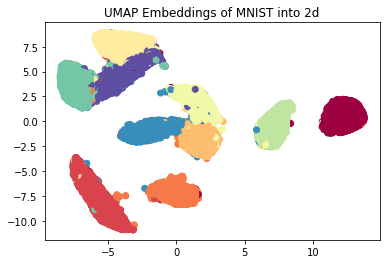

In [11]:
lowd_umap = umap.UMAP(n_components=2).fit(training_imgs)
lowd_umap_embeddings = lowd_umap.transform(training_imgs)
plt.scatter(lowd_umap_embeddings[:, 0], lowd_umap_embeddings[:, 1], c=np.argmax(training_lbs, axis=1), cmap='Spectral')
plt.title("UMAP Embeddings of MNIST into 2d")

In [12]:
umap_2kmeans = KMeans(n_clusters=10).fit(lowd_umap_embeddings)

In [14]:
label_map = label_to_label_map(umap_2kmeans.labels_, np.argmax(training_lbs, axis=1))
predictions = umap_2kmeans.predict(lowd_umap.transform(test_imgs))
predictions = [label_map(label) for label in predictions]
print("{0:.2f}%".format(np.sum(predictions == np.argmax(test_lbs, axis=1)) / len(test_lbs) * 100))

81.29%


### And we get much better accuracy with UMAP + KMeans (81.29%), but still not as good as even a single-layer softmax can get (~92%)

I clearly need to learn more about how dimensionality reduction algorithms are actually used. Classification seems like the wrong domain. They generate neat visualizations, but do these end up being useful???